In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, Easter, Day
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

# Load your datasets
df1 = pd.read_csv('/kaggle/input/new-data/payment_fraud_prediction_new_dataset_33k.csv')
df2 = pd.read_csv('/kaggle/input/new-data/payment_fraud_prediction_new_dataset_oct_jan_2k 1.csv')


# Rename columns in df2 to match df1
df2 = df2.rename(columns={
    'prediction_feedback_label': 'gatekeeper_label',
    'prediction_feedback_note': 'gatekeeper_note'
})

# Insert 'gatekeeper_status' in df2 at the same position as in df1
if 'gatekeeper_status' in df1.columns:
    status_index = df1.columns.get_loc('gatekeeper_status')
    df2.insert(status_index, 'gatekeeper_status', None)  # or set a default value

# Print columns after renaming and inserting
print("Columns in df1 after processing:", df1.columns.tolist())
print("Columns in df2 after processing:", df2.columns.tolist())

# Check if column names are the same
if list(df1.columns) == list(df2.columns):
    # Concatenate the datasets
    combined_df = pd.concat([df1, df2], ignore_index=True)
    print("Datasets have been appended successfully.")
else:
    print("Column names do not match. Datasets cannot be appended.")
    print("Columns in dataset1:", df1.columns.tolist())
    print("Columns in dataset2:", df2.columns.tolist())


Columns in df1 after processing: ['order_id', 'amount', 'payment_datetime', 'integration_channel', 'payment_status', 'send_money_mobile_number', 'receive_money_mobile_number', 'payment_type', 'prediction_label', 'gatekeeper_label', 'gatekeeper_status', 'gatekeeper_note', 'send_money_avg_successful_amount_sent_3months', 'send_money_last_successful_transaction_to_recipient_datetime_3months', 'send_money_last_failed_transaction_to_recipient_datetime_3months', 'send_money_failed_transactions_3months', 'send_money_daily_transaction_freq_1month', 'send_money_failed_transactions_24hrs', 'receive_money_last_transaction_date_3months', 'receive_money_avg_amount_received_3months', 'receive_money_total_transactions_received_3months', 'receive_money_daily_transaction_freq_3months', 'receive_money_unique_customer_count_3months', 'receive_money_avg_time_secs_between_transactions_3months', 'receive_money_avg_amount_received_1month', 'receive_money_total_transactions_received_1month', 'receive_money_da

In [3]:
combined_df.head()

,order_id,amount,payment_datetime,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,prediction_label,gatekeeper_label,...,receive_money_avg_amount_received_3months,receive_money_total_transactions_received_3months,receive_money_daily_transaction_freq_3months,receive_money_unique_customer_count_3months,receive_money_avg_time_secs_between_transactions_3months,receive_money_avg_amount_received_1month,receive_money_total_transactions_received_1month,receive_money_daily_transaction_freq_1week,receive_money_avg_time_secs_between_transactions_1week,receive_money_unique_customer_count_1week
0,47eb8ccdedc54c7a898d44bf01150a84,1.0,2024-05-23 15:50:40.617503,Mobile-iOS,True,233535502379,233530492122,mobilemoney,Legit,Fraud,...,233.625000,8.0,0.087912,7.0,789846.000000,182.0,4.0,0.0,0.0,0.0
1,a3cf55b2777848d7b17937094d4ed053,305.0,2024-05-20 11:53:49.117191,Mobile-App,True,233245000425,233558772938,mobilemoney,Legit,Fraud,...,24.615385,13.0,0.142857,10.0,403900.500000,1.0,1.0,0.0,0.0,0.0
2,d12ef2c6a21a47edb914e96a90efbec6,10.0,2024-05-23 19:55:41.287022,Mobile-App,True,233537075069,233200887965,card,Legit,Fraud,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,75bc51dd237e4fd7b12f978461a9b7d0,5.0,2024-05-20 12:50:10.057607,Mobile-App,True,233537414841,233502345065,mobilemoney,Fraud,Fraud,...,194.314286,35.0,0.384615,24.0,104474.264706,105.0,10.0,0.0,0.0,0.0
4,e7c1432969ec4776bbc564b8250a31ad,2.0,2024-05-23 16:19:33.327241,Mobile-App,True,233256812499,233596736032,mobilemoney,Legit,Fraud,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [4]:
df3 = pd.read_csv('/kaggle/input/new-data/unseen_transactions.csv')

In [5]:
df3.head()

,Unnamed: 0,order_id,amount,payment_datetime,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,prediction_label,...,receive_money_avg_amount_received_3months,receive_money_total_transactions_received_3months,receive_money_daily_transaction_freq_3months,receive_money_unique_customer_count_3months,receive_money_avg_time_secs_between_transactions_3months,receive_money_avg_amount_received_1month,receive_money_total_transactions_received_1month,receive_money_daily_transaction_freq_1week,receive_money_avg_time_secs_between_transactions_1week,receive_money_unique_customer_count_1week
0,19832,f989b64774b1434d99a7cc6d2b451f92,20.5,2024-05-03 10:29:34.442152,Mobile-App,True,233244824480,233257814112,hubtel,Legit,...,40.703125,32,0.351648,6,231621.645161,58.777778,9,0.285714,4938.0,1
1,19833,cff13bc28d33400bb1b90d0003074afb,22.0,2024-05-03 10:25:49.827944,Mobile-App,True,233559824133,233555166226,hubtel,Legit,...,22.155172,29,0.318681,6,271381.678571,19.333333,9,0.428571,297677.5,2
2,19834,8399024635794491914d4ba318c5677f,1600.0,2024-05-03 12:20:18.335458,Mobile-App,True,233240635675,233542008995,card,Legit,...,0.000000,0,0.000000,0,0.000000,0.000000,0,0.000000,0.0,0
3,19835,99fa13d6feba431da16ba8ab0cdcfa58,3.0,2024-05-03 11:38:00.172598,Mobile-App,True,233245728850,233241946752,mobilemoney,Legit,...,145.250000,8,0.087912,5,877041.428571,60.333333,6,0.428571,128467.5,2
4,19836,e88a6b8cbe36497fb86f11449dcfefbc,1.0,2024-05-03 11:41:04.868394,Mobile-App,False,233530987364,233537582963,mobilemoney,Legit,...,184.285714,7,0.076923,4,415557.666667,236.000000,5,0.000000,0.0,0


In [6]:
# Remove the unnamed column
df3 = df3.loc[:, ~df3.columns.str.contains('^Unnamed')]

In [7]:
df3.head()

,order_id,amount,payment_datetime,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,prediction_label,gatekeeper_label,...,receive_money_avg_amount_received_3months,receive_money_total_transactions_received_3months,receive_money_daily_transaction_freq_3months,receive_money_unique_customer_count_3months,receive_money_avg_time_secs_between_transactions_3months,receive_money_avg_amount_received_1month,receive_money_total_transactions_received_1month,receive_money_daily_transaction_freq_1week,receive_money_avg_time_secs_between_transactions_1week,receive_money_unique_customer_count_1week
0,f989b64774b1434d99a7cc6d2b451f92,20.5,2024-05-03 10:29:34.442152,Mobile-App,True,233244824480,233257814112,hubtel,Legit,Unknown,...,40.703125,32,0.351648,6,231621.645161,58.777778,9,0.285714,4938.0,1
1,cff13bc28d33400bb1b90d0003074afb,22.0,2024-05-03 10:25:49.827944,Mobile-App,True,233559824133,233555166226,hubtel,Legit,Unknown,...,22.155172,29,0.318681,6,271381.678571,19.333333,9,0.428571,297677.5,2
2,8399024635794491914d4ba318c5677f,1600.0,2024-05-03 12:20:18.335458,Mobile-App,True,233240635675,233542008995,card,Legit,Unknown,...,0.000000,0,0.000000,0,0.000000,0.000000,0,0.000000,0.0,0
3,99fa13d6feba431da16ba8ab0cdcfa58,3.0,2024-05-03 11:38:00.172598,Mobile-App,True,233245728850,233241946752,mobilemoney,Legit,Unknown,...,145.250000,8,0.087912,5,877041.428571,60.333333,6,0.428571,128467.5,2
4,e88a6b8cbe36497fb86f11449dcfefbc,1.0,2024-05-03 11:41:04.868394,Mobile-App,False,233530987364,233537582963,mobilemoney,Legit,Unknown,...,184.285714,7,0.076923,4,415557.666667,236.000000,5,0.000000,0.0,0


In [8]:
# Check if column names are the same
if list(df1.columns) == list(df2.columns):
    # Concatenate the datasets
    combined_df = pd.concat([combined_df, df3], ignore_index=True)
    print("Datasets have been appended successfully.")
else:
    print("Column names do not match. Datasets cannot be appended.")
    print("Columns in dataset1:", df1.columns.tolist())
    print("Columns in dataset2:", df2.columns.tolist())

Datasets have been appended successfully.


In [9]:
combined_df.head()

,order_id,amount,payment_datetime,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,prediction_label,gatekeeper_label,...,receive_money_avg_amount_received_3months,receive_money_total_transactions_received_3months,receive_money_daily_transaction_freq_3months,receive_money_unique_customer_count_3months,receive_money_avg_time_secs_between_transactions_3months,receive_money_avg_amount_received_1month,receive_money_total_transactions_received_1month,receive_money_daily_transaction_freq_1week,receive_money_avg_time_secs_between_transactions_1week,receive_money_unique_customer_count_1week
0,47eb8ccdedc54c7a898d44bf01150a84,1.0,2024-05-23 15:50:40.617503,Mobile-iOS,True,233535502379,233530492122,mobilemoney,Legit,Fraud,...,233.625000,8.0,0.087912,7.0,789846.000000,182.0,4.0,0.0,0.0,0.0
1,a3cf55b2777848d7b17937094d4ed053,305.0,2024-05-20 11:53:49.117191,Mobile-App,True,233245000425,233558772938,mobilemoney,Legit,Fraud,...,24.615385,13.0,0.142857,10.0,403900.500000,1.0,1.0,0.0,0.0,0.0
2,d12ef2c6a21a47edb914e96a90efbec6,10.0,2024-05-23 19:55:41.287022,Mobile-App,True,233537075069,233200887965,card,Legit,Fraud,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,75bc51dd237e4fd7b12f978461a9b7d0,5.0,2024-05-20 12:50:10.057607,Mobile-App,True,233537414841,233502345065,mobilemoney,Fraud,Fraud,...,194.314286,35.0,0.384615,24.0,104474.264706,105.0,10.0,0.0,0.0,0.0
4,e7c1432969ec4776bbc564b8250a31ad,2.0,2024-05-23 16:19:33.327241,Mobile-App,True,233256812499,233596736032,mobilemoney,Legit,Fraud,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [10]:
df = combined_df

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42140 entries, 0 to 42139
Data columns (total 29 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   order_id                                                              42140 non-null  object 
 1   amount                                                                42140 non-null  float64
 2   payment_datetime                                                      42140 non-null  object 
 3   integration_channel                                                   42140 non-null  object 
 4   payment_status                                                        42140 non-null  bool   
 5   send_money_mobile_number                                              42140 non-null  int64  
 6   receive_money_mobile_number                                           42140 non-null  int64  


In [12]:
# Count duplicates in the 'order_id' column
duplicate_count = df.duplicated(subset='order_id').sum()

# Display the count of duplicates
print(f"Number of duplicate order_ids: {duplicate_count}")

Number of duplicate order_ids: 50


In [13]:

df = df.set_index('order_id').drop_duplicates()

In [14]:
# Count duplicates in the 'order_id' column
duplicate_count = df.duplicated().sum()

# Display the count of duplicates
print(duplicate_count)

0


In [15]:
receive_money = df[['amount', 'payment_datetime', 'integration_channel', 
     'payment_status', 'send_money_mobile_number', 'receive_money_mobile_number', 
     'payment_type', 'prediction_label', 'gatekeeper_label', 'gatekeeper_status', 'gatekeeper_note', 
     'receive_money_last_transaction_date_3months', 'receive_money_avg_amount_received_3months', 
     'receive_money_total_transactions_received_3months', 'receive_money_daily_transaction_freq_3months', 
     'receive_money_unique_customer_count_3months', 'receive_money_avg_time_secs_between_transactions_3months', 
     'receive_money_avg_amount_received_1month', 'receive_money_total_transactions_received_1month', 
     'receive_money_daily_transaction_freq_1week', 'receive_money_avg_time_secs_between_transactions_1week', 
     'receive_money_unique_customer_count_1week']]

In [16]:
send_money = df[['amount', 'payment_datetime', 'integration_channel', 'payment_status', 
                'send_money_mobile_number', 'receive_money_mobile_number', 'payment_type', 'prediction_label', 
                'gatekeeper_label', 'gatekeeper_status', 'gatekeeper_note', 'send_money_avg_successful_amount_sent_3months', 
                'send_money_last_successful_transaction_to_recipient_datetime_3months', 
                'send_money_last_failed_transaction_to_recipient_datetime_3months', 'send_money_failed_transactions_3months', 
                'send_money_daily_transaction_freq_1month', 'send_money_failed_transactions_24hrs']]

In [17]:
# Filter for rows where 'gatekeeper_label' is 'Fraud' or 'Legit'
data1 = send_money[send_money['gatekeeper_label'].isin(['Fraud', 'Legit'])]

In [18]:
data1.head()

,amount,payment_datetime,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,prediction_label,gatekeeper_label,gatekeeper_status,gatekeeper_note,send_money_avg_successful_amount_sent_3months,send_money_last_successful_transaction_to_recipient_datetime_3months,send_money_last_failed_transaction_to_recipient_datetime_3months,send_money_failed_transactions_3months,send_money_daily_transaction_freq_1month,send_money_failed_transactions_24hrs
order_id,,,,,,,,,,,,,,,,,
47eb8ccdedc54c7a898d44bf01150a84,1.0,2024-05-23 15:50:40.617503,Mobile-iOS,True,233535502379,233530492122,mobilemoney,Legit,Fraud,Declined,Unsolicited Prompt,12.245370,NaN,NaN,7.0,2.366667,0.0
a3cf55b2777848d7b17937094d4ed053,305.0,2024-05-20 11:53:49.117191,Mobile-App,True,233245000425,233558772938,mobilemoney,Legit,Fraud,Declined,Money doubling scam,NaN,NaN,NaN,0.0,0.000000,0.0
d12ef2c6a21a47edb914e96a90efbec6,10.0,2024-05-23 19:55:41.287022,Mobile-App,True,233537075069,233200887965,card,Legit,Fraud,Declined,Fraud Testing,57.636667,NaN,NaN,2.0,0.166667,1.0
75bc51dd237e4fd7b12f978461a9b7d0,5.0,2024-05-20 12:50:10.057607,Mobile-App,True,233537414841,233502345065,mobilemoney,Fraud,Fraud,Declined,Money doubling scam,NaN,NaN,NaN,16.0,0.400000,0.0
e7c1432969ec4776bbc564b8250a31ad,2.0,2024-05-23 16:19:33.327241,Mobile-App,True,233256812499,233596736032,mobilemoney,Legit,Fraud,Declined,Fraud Testing,43.585000,NaN,NaN,4.0,0.333333,0.0


In [19]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3650 entries, 47eb8ccdedc54c7a898d44bf01150a84 to 378d8c30c0ef490e907bcfd43069d8e1
Data columns (total 17 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   amount                                                                3650 non-null   float64
 1   payment_datetime                                                      3650 non-null   object 
 2   integration_channel                                                   3650 non-null   object 
 3   payment_status                                                        3650 non-null   bool   
 4   send_money_mobile_number                                              3650 non-null   int64  
 5   receive_money_mobile_number                                           3650 non-null   int64  
 6   payment_type                              

In [20]:
## Process Phone Number Features

def extract_phone_number_initials(phone_number):
    phone_number_initials = str(phone_number)[:5]
    return phone_number_initials

def get_telco(phone_number):
    telcos = {
    "23323": "Glo",
    "23324": "MTN",
    "23325": "MTN",
    "23353": "MTN",
    "23354": "MTN",
    "23355": "MTN",
    "23359": "MTN",
    "23327": "AT",
    "23357": "AT",
    "23326": "AT",
    "23356": "AT",
    "23328": "Expresso",
    "23320": "Telecel",
    "23350": "Telecel",
    }
    initial_digits= extract_phone_number_initials(phone_number)
    telco = telcos[initial_digits]
    return telco

In [21]:
data1['send_money_phone_number_initials'] = data1['send_money_mobile_number'].apply(extract_phone_number_initials)
data1['receive_money_phone_number_initials'] = data1['receive_money_mobile_number'].apply(extract_phone_number_initials)

##extract telcos
data1['send_money_telco'] = data1['send_money_mobile_number'].apply(get_telco)
data1['receive_money_telco'] = data1['receive_money_mobile_number'].apply(get_telco)

In [22]:
# # Label encoding
integration_channel_mapping = {'Mobile-Android': 'Mobile','Mobile-iOS': 'Mobile','Mobile-App':'Mobile','Mobile':'Mobile','consumer_web':'Web'}
data1['integration_channel'] = data1['integration_channel'].map(integration_channel_mapping)

In [23]:
data1['gatekeeper_label'].value_counts()

gatekeeper_label
Fraud    2657
Legit     993
Name: count, dtype: int64

In [24]:
data1['payment_datetime'] = pd.to_datetime(data1['payment_datetime'], format='ISO8601')

# Sample list of datetime column names, replace with your actual column names
datetime_columns = ['payment_datetime','send_money_last_successful_transaction_to_recipient_datetime_3months',
                     'send_money_last_failed_transaction_to_recipient_datetime_3months'] 

# Ensure datetime columns are correctly parsed
for column in datetime_columns:
    data1[column] = pd.to_datetime(data1[column], errors='coerce')

# Extract features from each datetime column
for column in datetime_columns:
    data1[f'{column}_day'] = data1[column].dt.day
    data1[f'{column}_hour'] = data1[column].dt.hour
    data1[f'{column}_dayofweek'] = data1[column].dt.dayofweek
    data1[f'{column}_is_weekend'] = data1[column].dt.dayofweek >= 5
    data1[f'{column}_time_period'] = data1[column].apply(lambda x: 'morning' if 5 <= x.hour < 12 else 'afternoon' if 12 <= x.hour < 17 else 'evening' if 17 <= x.hour < 21 else 'night')

In [25]:
data1.head()

,amount,payment_datetime,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,prediction_label,gatekeeper_label,gatekeeper_status,...,send_money_last_successful_transaction_to_recipient_datetime_3months_day,send_money_last_successful_transaction_to_recipient_datetime_3months_hour,send_money_last_successful_transaction_to_recipient_datetime_3months_dayofweek,send_money_last_successful_transaction_to_recipient_datetime_3months_is_weekend,send_money_last_successful_transaction_to_recipient_datetime_3months_time_period,send_money_last_failed_transaction_to_recipient_datetime_3months_day,send_money_last_failed_transaction_to_recipient_datetime_3months_hour,send_money_last_failed_transaction_to_recipient_datetime_3months_dayofweek,send_money_last_failed_transaction_to_recipient_datetime_3months_is_weekend,send_money_last_failed_transaction_to_recipient_datetime_3months_time_period
order_id,,,,,,,,,,,,,,,,,,,,,
47eb8ccdedc54c7a898d44bf01150a84,1.0,2024-05-23 15:50:40.617503,Mobile,True,233535502379,233530492122,mobilemoney,Legit,Fraud,Declined,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night
a3cf55b2777848d7b17937094d4ed053,305.0,2024-05-20 11:53:49.117191,Mobile,True,233245000425,233558772938,mobilemoney,Legit,Fraud,Declined,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night
d12ef2c6a21a47edb914e96a90efbec6,10.0,2024-05-23 19:55:41.287022,Mobile,True,233537075069,233200887965,card,Legit,Fraud,Declined,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night
75bc51dd237e4fd7b12f978461a9b7d0,5.0,2024-05-20 12:50:10.057607,Mobile,True,233537414841,233502345065,mobilemoney,Fraud,Fraud,Declined,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night
e7c1432969ec4776bbc564b8250a31ad,2.0,2024-05-23 16:19:33.327241,Mobile,True,233256812499,233596736032,mobilemoney,Legit,Fraud,Declined,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night


In [26]:
data1.columns

Index(['amount', 'payment_datetime', 'integration_channel', 'payment_status',
       'send_money_mobile_number', 'receive_money_mobile_number',
       'payment_type', 'prediction_label', 'gatekeeper_label',
       'gatekeeper_status', 'gatekeeper_note',
       'send_money_avg_successful_amount_sent_3months',
       'send_money_last_successful_transaction_to_recipient_datetime_3months',
       'send_money_last_failed_transaction_to_recipient_datetime_3months',
       'send_money_failed_transactions_3months',
       'send_money_daily_transaction_freq_1month',
       'send_money_failed_transactions_24hrs',
       'send_money_phone_number_initials',
       'receive_money_phone_number_initials', 'send_money_telco',
       'receive_money_telco', 'payment_datetime_day', 'payment_datetime_hour',
       'payment_datetime_dayofweek', 'payment_datetime_is_weekend',
       'payment_datetime_time_period',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_day',
       'sen

In [27]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3650 entries, 47eb8ccdedc54c7a898d44bf01150a84 to 378d8c30c0ef490e907bcfd43069d8e1
Data columns (total 36 columns):
 #   Column                                                                            Non-Null Count  Dtype         
---  ------                                                                            --------------  -----         
 0   amount                                                                            3650 non-null   float64       
 1   payment_datetime                                                                  3650 non-null   datetime64[ns]
 2   integration_channel                                                               3650 non-null   object        
 3   payment_status                                                                    3650 non-null   bool          
 4   send_money_mobile_number                                                          3650 non-null   int64         
 5   receive_

In [28]:
data1 = data1[['amount','integration_channel',
       'payment_status', 'payment_type',
       'gatekeeper_label', 
       'send_money_avg_successful_amount_sent_3months',
       'send_money_last_successful_transaction_to_recipient_datetime_3months',
       'send_money_last_failed_transaction_to_recipient_datetime_3months',
       'send_money_failed_transactions_3months',
       'send_money_daily_transaction_freq_1month',
       'send_money_failed_transactions_24hrs',
       'send_money_phone_number_initials',
       'receive_money_phone_number_initials', 'send_money_telco',
       'receive_money_telco', 'payment_datetime_day', 'payment_datetime_hour',
       'payment_datetime_dayofweek', 'payment_datetime_is_weekend',
       'payment_datetime_time_period',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_day',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_hour',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_dayofweek',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_is_weekend',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_time_period',
       'send_money_last_failed_transaction_to_recipient_datetime_3months_day',
       'send_money_last_failed_transaction_to_recipient_datetime_3months_hour',
       'send_money_last_failed_transaction_to_recipient_datetime_3months_dayofweek',
       'send_money_last_failed_transaction_to_recipient_datetime_3months_is_weekend',
       'send_money_last_failed_transaction_to_recipient_datetime_3months_time_period']]

In [29]:
# Filter for rows where 'gatekeeper_label' is 'Fraud' or 'Legit'
data1 = data1[data1['gatekeeper_label'].isin(['Fraud', 'Legit'])]

In [30]:
data1.head()

,amount,integration_channel,payment_status,payment_type,gatekeeper_label,send_money_avg_successful_amount_sent_3months,send_money_last_successful_transaction_to_recipient_datetime_3months,send_money_last_failed_transaction_to_recipient_datetime_3months,send_money_failed_transactions_3months,send_money_daily_transaction_freq_1month,...,send_money_last_successful_transaction_to_recipient_datetime_3months_day,send_money_last_successful_transaction_to_recipient_datetime_3months_hour,send_money_last_successful_transaction_to_recipient_datetime_3months_dayofweek,send_money_last_successful_transaction_to_recipient_datetime_3months_is_weekend,send_money_last_successful_transaction_to_recipient_datetime_3months_time_period,send_money_last_failed_transaction_to_recipient_datetime_3months_day,send_money_last_failed_transaction_to_recipient_datetime_3months_hour,send_money_last_failed_transaction_to_recipient_datetime_3months_dayofweek,send_money_last_failed_transaction_to_recipient_datetime_3months_is_weekend,send_money_last_failed_transaction_to_recipient_datetime_3months_time_period
order_id,,,,,,,,,,,,,,,,,,,,,
47eb8ccdedc54c7a898d44bf01150a84,1.0,Mobile,True,mobilemoney,Fraud,12.245370,NaT,NaT,7.0,2.366667,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night
a3cf55b2777848d7b17937094d4ed053,305.0,Mobile,True,mobilemoney,Fraud,NaN,NaT,NaT,0.0,0.000000,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night
d12ef2c6a21a47edb914e96a90efbec6,10.0,Mobile,True,card,Fraud,57.636667,NaT,NaT,2.0,0.166667,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night
75bc51dd237e4fd7b12f978461a9b7d0,5.0,Mobile,True,mobilemoney,Fraud,NaN,NaT,NaT,16.0,0.400000,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night
e7c1432969ec4776bbc564b8250a31ad,2.0,Mobile,True,mobilemoney,Fraud,43.585000,NaT,NaT,4.0,0.333333,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night


In [31]:
# Label encoding
label_mapping = {'Fraud': 1, 'Legit': 0}
data1['gatekeeper_label'] = data1['gatekeeper_label'].map(label_mapping)

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, Normalizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import joblib
import tarfile

In [33]:
# Define features and target
all_features = data1.columns.drop('gatekeeper_label')
numeric_features = data1[all_features].select_dtypes(include=['int64', 'float64', 'int32', 'UInt32']).columns
categorical_features = data1[all_features].select_dtypes(include=['object', 'bool']).columns

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the features (X) and target (y)
X = data1.drop(columns=['gatekeeper_label'])
y = data1['gatekeeper_label']

# Split the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply the transformations and use SMOTE
smote = SMOTE(random_state=42)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

In [34]:

def plot_feature_importances(model, model_name):

    classifier = model.named_steps['classifier']

    feature_importances = classifier.feature_importances_
 
    # Combine feature names from numeric and categorical features after one-hot encoding

    categorical_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)

    all_feature_names = np.concatenate([numeric_features, categorical_feature_names])
 
    # Create a DataFrame for feature importances

    feature_importances_df = pd.DataFrame({

        'Feature': all_feature_names,

        'Importance': feature_importances * 100

    }).sort_values(by='Importance', ascending=False)
 
    # Display feature importances

    print(feature_importances_df)
 
    # Plot feature importances

    plt.figure(figsize=(10, 8))

    plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])

    plt.xlabel('Importance')

    plt.ylabel('Feature')

    plt.title(f'{model_name.title()} - Feature Importances')

    plt.gca().invert_yaxis()

    plt.show()

from sklearn.metrics import roc_auc_score
 
def plot_roc_auc(x_test,y_test,model,model_name):

    # Get the predicted probabilities

    y_pred_proba = model.predict_proba(X_test)[:, 1]
 
    # Compute ROC curve and ROC area

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # auc = auc(fpr, tpr)

    roc_auc = roc_auc_score(y_test, y_pred_proba)
 
    # Plot ROC curve

    plt.figure()

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title(f'{model_name.title()} - ROC Curve - Score {roc_auc:.2f}')

    plt.legend(loc="lower right")

    plt.show()

    print(f"ROC AUC - {roc_auc:.2f}")

In [35]:
# Tune Gradient Boosting
gb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
gb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'preprocessor__cat__encoder': [OrdinalEncoder(), OneHotEncoder(handle_unknown='ignore')],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), Normalizer()],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7]
}
gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=1)
gb_grid_search.fit(X_train, y_train)
best_gb = gb_grid_search.best_estimator_.named_steps['classifier']

Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [36]:
# Predictions
y_pred_gradient_boost =  gb_grid_search.best_estimator_.predict(X_test)
y_pred_proba_gradient_boost =  gb_grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [37]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import pandas as pd

# Assume you have your model and the datasets ready
# model = ...
# X_train, X_test, y_train, y_test = ...
y_train_pred=  gb_grid_search.best_estimator_.predict(X_train)

y_test_pred = gb_grid_search.best_estimator_.predict(X_test)

# Calculate metrics for training data
train_f1 = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate metrics for test data
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Create a DataFrame for easy comparison
metrics_df = pd.DataFrame({
    'Metric': ['F1 Score', 'Precision', 'Recall', 'Accuracy'],
    'Train': [train_f1, train_precision, train_recall, train_accuracy],
    'Test': [test_f1, test_precision, test_recall, test_accuracy]
})

# Display the DataFrame
print(metrics_df)

      Metric  Train      Test
0   F1 Score    1.0  0.953991
1  Precision    1.0  0.951311
2     Recall    1.0  0.956685
3   Accuracy    1.0  0.932877


In [38]:
print(classification_report(y_test,y_pred_gradient_boost))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       199
           1       0.95      0.96      0.95       531

    accuracy                           0.93       730
   macro avg       0.92      0.91      0.91       730
weighted avg       0.93      0.93      0.93       730



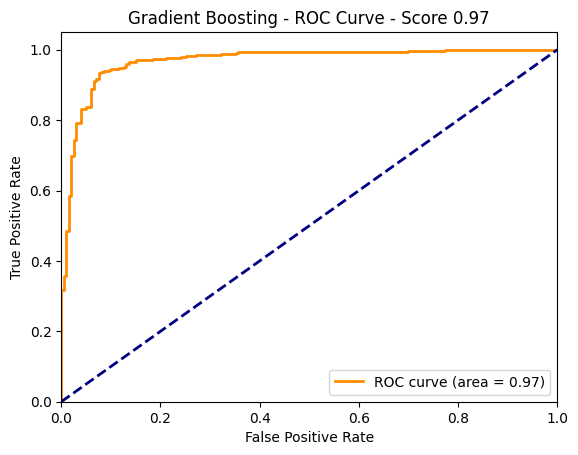

ROC AUC - 0.97


In [39]:
plot_roc_auc(X_test,y_test,gb_grid_search.best_estimator_,"Gradient Boosting")

In [40]:
import joblib
import tarfile

# Save the model as a pickle file
pickle_filename = 'best_gb.pkl'
joblib.dump(gb_grid_search.best_estimator_, pickle_filename)

# Save the model as a tar.gz file
tar_filename = 'best_gb.tar.gz'
with tarfile.open(tar_filename, "w:gz") as tar:
    tar.add(pickle_filename, arcname='best_gb.pkl')

# Save the model as a joblib file
joblib_filename = 'best_gb.joblib'
joblib.dump(gb_grid_search.best_estimator_, joblib_filename)

# Save both the pickle file and the joblib file into a tar.gz file
combined_tar_filename = 'best_gb_combined.tar.gz'
with tarfile.open(combined_tar_filename, "w:gz") as tar:
    tar.add(pickle_filename, arcname='best_gb.pkl')
    tar.add(joblib_filename, arcname='best_gb.joblib')

In [41]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 379bf0c52e96428daa6592a953af4342 to 1cf0e86be3a84c43b773cec31ad1f43c
Data columns (total 29 columns):
 #   Column                                                                            Non-Null Count  Dtype         
---  ------                                                                            --------------  -----         
 0   amount                                                                            730 non-null    float64       
 1   integration_channel                                                               730 non-null    object        
 2   payment_status                                                                    730 non-null    bool          
 3   payment_type                                                                      730 non-null    object        
 4   send_money_avg_successful_amount_sent_3months                                     364 non-null    float64       
 5   send_mone

In [42]:
unseen = pd.read_csv('/kaggle/input/new-data/unseen_transactions.csv')

In [43]:
# Remove the unnamed column
unseen = unseen.loc[:, ~unseen.columns.str.contains('^Unnamed')]

In [44]:
unseen.head()

,order_id,amount,payment_datetime,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,prediction_label,gatekeeper_label,...,receive_money_avg_amount_received_3months,receive_money_total_transactions_received_3months,receive_money_daily_transaction_freq_3months,receive_money_unique_customer_count_3months,receive_money_avg_time_secs_between_transactions_3months,receive_money_avg_amount_received_1month,receive_money_total_transactions_received_1month,receive_money_daily_transaction_freq_1week,receive_money_avg_time_secs_between_transactions_1week,receive_money_unique_customer_count_1week
0,f989b64774b1434d99a7cc6d2b451f92,20.5,2024-05-03 10:29:34.442152,Mobile-App,True,233244824480,233257814112,hubtel,Legit,Unknown,...,40.703125,32,0.351648,6,231621.645161,58.777778,9,0.285714,4938.0,1
1,cff13bc28d33400bb1b90d0003074afb,22.0,2024-05-03 10:25:49.827944,Mobile-App,True,233559824133,233555166226,hubtel,Legit,Unknown,...,22.155172,29,0.318681,6,271381.678571,19.333333,9,0.428571,297677.5,2
2,8399024635794491914d4ba318c5677f,1600.0,2024-05-03 12:20:18.335458,Mobile-App,True,233240635675,233542008995,card,Legit,Unknown,...,0.000000,0,0.000000,0,0.000000,0.000000,0,0.000000,0.0,0
3,99fa13d6feba431da16ba8ab0cdcfa58,3.0,2024-05-03 11:38:00.172598,Mobile-App,True,233245728850,233241946752,mobilemoney,Legit,Unknown,...,145.250000,8,0.087912,5,877041.428571,60.333333,6,0.428571,128467.5,2
4,e88a6b8cbe36497fb86f11449dcfefbc,1.0,2024-05-03 11:41:04.868394,Mobile-App,False,233530987364,233537582963,mobilemoney,Legit,Unknown,...,184.285714,7,0.076923,4,415557.666667,236.000000,5,0.000000,0.0,0


In [45]:
# Filter for rows where 'gatekeeper_label' is 'Fraud' or 'Legit'
unseen = unseen[unseen['gatekeeper_label'].isin(['Fraud', 'Legit'])]

In [46]:
## Process Phone Number Features

def extract_phone_number_initials(phone_number):
    phone_number_initials = str(phone_number)[:5]
    return phone_number_initials

def get_telco(phone_number):
    telcos = {
    "23323": "Glo",
    "23324": "MTN",
    "23325": "MTN",
    "23353": "MTN",
    "23354": "MTN",
    "23355": "MTN",
    "23359": "MTN",
    "23327": "AT",
    "23357": "AT",
    "23326": "AT",
    "23356": "AT",
    "23328": "Expresso",
    "23320": "Telecel",
    "23350": "Telecel",
    }
    initial_digits= extract_phone_number_initials(phone_number)
    telco = telcos[initial_digits]
    return telco

In [47]:
unseen['send_money_phone_number_initials'] = unseen['send_money_mobile_number'].apply(extract_phone_number_initials)
unseen['receive_money_phone_number_initials'] = unseen['receive_money_mobile_number'].apply(extract_phone_number_initials)

##extract telcos
unseen['send_money_telco'] = unseen['send_money_mobile_number'].apply(get_telco)
unseen['receive_money_telco'] = unseen['receive_money_mobile_number'].apply(get_telco)

In [48]:
# # Label encoding
integration_channel_mapping = {'Mobile-Android': 'Mobile','Mobile-iOS': 'Mobile','Mobile-App':'Mobile','Mobile':'Mobile','consumer_web':'Web'}
unseen['integration_channel'] = unseen['integration_channel'].map(integration_channel_mapping)

In [49]:
unseen['payment_datetime'] = pd.to_datetime(unseen['payment_datetime'], format='ISO8601')

# Sample list of datetime column names, replace with your actual column names
datetime_columns = ['payment_datetime','send_money_last_successful_transaction_to_recipient_datetime_3months',
                     'send_money_last_failed_transaction_to_recipient_datetime_3months'] 

# Ensure datetime columns are correctly parsed
for column in datetime_columns:
    unseen[column] = pd.to_datetime(unseen[column], errors='coerce')

# Extract features from each datetime column
for column in datetime_columns:
    unseen[f'{column}_day'] = unseen[column].dt.day
    unseen[f'{column}_hour'] = unseen[column].dt.hour
    unseen[f'{column}_dayofweek'] = unseen[column].dt.dayofweek
    unseen[f'{column}_is_weekend'] = unseen[column].dt.dayofweek >= 5
    unseen[f'{column}_is_month_start'] = unseen[column].dt.is_month_start
    unseen[f'{column}_is_month_end'] = unseen[column].dt.is_month_end
    unseen[f'{column}_time_period'] = unseen[column].apply(lambda x: 'morning' if 5 <= x.hour < 12 else 'afternoon' if 12 <= x.hour < 17 else 'evening' if 17 <= x.hour < 21 else 'night')

In [50]:
unseen = unseen[['amount','integration_channel',
       'payment_status', 'send_money_mobile_number',
       'receive_money_mobile_number', 'payment_type',
       'gatekeeper_label', 
       'send_money_avg_successful_amount_sent_3months',
       'send_money_last_successful_transaction_to_recipient_datetime_3months',
       'send_money_last_failed_transaction_to_recipient_datetime_3months',
       'send_money_failed_transactions_3months',
       'send_money_daily_transaction_freq_1month',
       'send_money_failed_transactions_24hrs',
       'send_money_phone_number_initials',
       'receive_money_phone_number_initials', 'send_money_telco',
       'receive_money_telco', 'payment_datetime_day', 'payment_datetime_hour',
       'payment_datetime_dayofweek', 'payment_datetime_is_weekend',
       'payment_datetime_time_period',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_day',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_hour',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_dayofweek',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_is_weekend',
       'send_money_last_successful_transaction_to_recipient_datetime_3months_time_period',
       'send_money_last_failed_transaction_to_recipient_datetime_3months_day',
       'send_money_last_failed_transaction_to_recipient_datetime_3months_hour',
       'send_money_last_failed_transaction_to_recipient_datetime_3months_dayofweek',
       'send_money_last_failed_transaction_to_recipient_datetime_3months_is_weekend',
       'send_money_last_failed_transaction_to_recipient_datetime_3months_time_period']]

In [51]:
# Filter for rows where 'gatekeeper_label' is 'Fraud' or 'Legit'
unseen = unseen[unseen['gatekeeper_label'].isin(['Fraud', 'Legit'])]

In [52]:
unseen.head()

,amount,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,gatekeeper_label,send_money_avg_successful_amount_sent_3months,send_money_last_successful_transaction_to_recipient_datetime_3months,send_money_last_failed_transaction_to_recipient_datetime_3months,...,send_money_last_successful_transaction_to_recipient_datetime_3months_day,send_money_last_successful_transaction_to_recipient_datetime_3months_hour,send_money_last_successful_transaction_to_recipient_datetime_3months_dayofweek,send_money_last_successful_transaction_to_recipient_datetime_3months_is_weekend,send_money_last_successful_transaction_to_recipient_datetime_3months_time_period,send_money_last_failed_transaction_to_recipient_datetime_3months_day,send_money_last_failed_transaction_to_recipient_datetime_3months_hour,send_money_last_failed_transaction_to_recipient_datetime_3months_dayofweek,send_money_last_failed_transaction_to_recipient_datetime_3months_is_weekend,send_money_last_failed_transaction_to_recipient_datetime_3months_time_period
91,50.0,Mobile,True,233202437997,233540465231,hubtel,Legit,152.330102,NaT,NaT,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night
334,10.0,Mobile,True,233559824133,233550140330,hubtel,Legit,46.688838,2024-03-24 14:35:58.133400,NaT,...,24.0,14.0,6.0,True,afternoon,NaN,NaN,NaN,False,night
389,120.0,Web,True,233545673588,233247303525,hubtel,Legit,161.615746,2024-04-16 15:47:37.702285,NaT,...,16.0,15.0,1.0,False,afternoon,NaN,NaN,NaN,False,night
668,130.0,Mobile,True,233599963109,233545990848,hubtel,Legit,64.541707,2024-03-25 16:44:05.522828,NaT,...,25.0,16.0,0.0,False,afternoon,NaN,NaN,NaN,False,night
746,13.0,Mobile,True,233256351951,233551032236,hubtel,Legit,12.000000,2024-05-03 08:05:05.831853,NaT,...,3.0,8.0,4.0,False,morning,NaN,NaN,NaN,False,night


In [53]:
# Label encoding
label_mapping = {'Fraud': 1, 'Legit': 0}
unseen['gatekeeper_label'] = unseen['gatekeeper_label'].map(label_mapping)

In [54]:
unseen.head()

,amount,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,gatekeeper_label,send_money_avg_successful_amount_sent_3months,send_money_last_successful_transaction_to_recipient_datetime_3months,send_money_last_failed_transaction_to_recipient_datetime_3months,...,send_money_last_successful_transaction_to_recipient_datetime_3months_day,send_money_last_successful_transaction_to_recipient_datetime_3months_hour,send_money_last_successful_transaction_to_recipient_datetime_3months_dayofweek,send_money_last_successful_transaction_to_recipient_datetime_3months_is_weekend,send_money_last_successful_transaction_to_recipient_datetime_3months_time_period,send_money_last_failed_transaction_to_recipient_datetime_3months_day,send_money_last_failed_transaction_to_recipient_datetime_3months_hour,send_money_last_failed_transaction_to_recipient_datetime_3months_dayofweek,send_money_last_failed_transaction_to_recipient_datetime_3months_is_weekend,send_money_last_failed_transaction_to_recipient_datetime_3months_time_period
91,50.0,Mobile,True,233202437997,233540465231,hubtel,0,152.330102,NaT,NaT,...,NaN,NaN,NaN,False,night,NaN,NaN,NaN,False,night
334,10.0,Mobile,True,233559824133,233550140330,hubtel,0,46.688838,2024-03-24 14:35:58.133400,NaT,...,24.0,14.0,6.0,True,afternoon,NaN,NaN,NaN,False,night
389,120.0,Web,True,233545673588,233247303525,hubtel,0,161.615746,2024-04-16 15:47:37.702285,NaT,...,16.0,15.0,1.0,False,afternoon,NaN,NaN,NaN,False,night
668,130.0,Mobile,True,233599963109,233545990848,hubtel,0,64.541707,2024-03-25 16:44:05.522828,NaT,...,25.0,16.0,0.0,False,afternoon,NaN,NaN,NaN,False,night
746,13.0,Mobile,True,233256351951,233551032236,hubtel,0,12.000000,2024-05-03 08:05:05.831853,NaT,...,3.0,8.0,4.0,False,morning,NaN,NaN,NaN,False,night


In [55]:
#X = unseen.drop(columns=['gatekeeper_label'])

In [56]:
X = unseen.drop(columns = 'gatekeeper_label')
y = unseen['gatekeeper_label']

In [57]:
model = joblib.load('best_gb.joblib')

In [58]:
y_pred = model.predict(X)

In [59]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       392
           1       0.91      0.95      0.93        21

    accuracy                           0.99       413
   macro avg       0.95      0.97      0.96       413
weighted avg       0.99      0.99      0.99       413



In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413 entries, 91 to 19617
Data columns (total 31 columns):
 #   Column                                                                            Non-Null Count  Dtype         
---  ------                                                                            --------------  -----         
 0   amount                                                                            413 non-null    float64       
 1   integration_channel                                                               413 non-null    object        
 2   payment_status                                                                    413 non-null    bool          
 3   send_money_mobile_number                                                          413 non-null    int64         
 4   receive_money_mobile_number                                                       413 non-null    int64         
 5   payment_type                                                      

In [61]:
# Filter for rows where 'gatekeeper_label' is 'Fraud' or 'Legit'
data2 = receive_money[receive_money['gatekeeper_label'].isin(['Fraud', 'Legit'])]

In [62]:
data2.head()

,amount,payment_datetime,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,prediction_label,gatekeeper_label,gatekeeper_status,...,receive_money_avg_amount_received_3months,receive_money_total_transactions_received_3months,receive_money_daily_transaction_freq_3months,receive_money_unique_customer_count_3months,receive_money_avg_time_secs_between_transactions_3months,receive_money_avg_amount_received_1month,receive_money_total_transactions_received_1month,receive_money_daily_transaction_freq_1week,receive_money_avg_time_secs_between_transactions_1week,receive_money_unique_customer_count_1week
order_id,,,,,,,,,,,,,,,,,,,,,
47eb8ccdedc54c7a898d44bf01150a84,1.0,2024-05-23 15:50:40.617503,Mobile-iOS,True,233535502379,233530492122,mobilemoney,Legit,Fraud,Declined,...,233.625000,8.0,0.087912,7.0,789846.000000,182.0,4.0,0.0,0.0,0.0
a3cf55b2777848d7b17937094d4ed053,305.0,2024-05-20 11:53:49.117191,Mobile-App,True,233245000425,233558772938,mobilemoney,Legit,Fraud,Declined,...,24.615385,13.0,0.142857,10.0,403900.500000,1.0,1.0,0.0,0.0,0.0
d12ef2c6a21a47edb914e96a90efbec6,10.0,2024-05-23 19:55:41.287022,Mobile-App,True,233537075069,233200887965,card,Legit,Fraud,Declined,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
75bc51dd237e4fd7b12f978461a9b7d0,5.0,2024-05-20 12:50:10.057607,Mobile-App,True,233537414841,233502345065,mobilemoney,Fraud,Fraud,Declined,...,194.314286,35.0,0.384615,24.0,104474.264706,105.0,10.0,0.0,0.0,0.0
e7c1432969ec4776bbc564b8250a31ad,2.0,2024-05-23 16:19:33.327241,Mobile-App,True,233256812499,233596736032,mobilemoney,Legit,Fraud,Declined,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [63]:
## Process Phone Number Features

def extract_phone_number_initials(phone_number):
    phone_number_initials = str(phone_number)[:5]
    return phone_number_initials

def get_telco(phone_number):
    telcos = {
    "23323": "Glo",
    "23324": "MTN",
    "23325": "MTN",
    "23353": "MTN",
    "23354": "MTN",
    "23355": "MTN",
    "23359": "MTN",
    "23327": "AT",
    "23357": "AT",
    "23326": "AT",
    "23356": "AT",
    "23328": "Expresso",
    "23320": "Telecel",
    "23350": "Telecel",
    }
    initial_digits= extract_phone_number_initials(phone_number)
    telco = telcos[initial_digits]
    return telco

In [64]:
data2['send_money_phone_number_initials'] = data2['send_money_mobile_number'].apply(extract_phone_number_initials)
data2['receive_money_phone_number_initials'] = data2['receive_money_mobile_number'].apply(extract_phone_number_initials)

##extract telcos
data2['send_money_telco'] = data2['send_money_mobile_number'].apply(get_telco)
data2['receive_money_telco'] = data2['receive_money_mobile_number'].apply(get_telco)

In [65]:
# # Label encoding
integration_channel_mapping = {'Mobile-Android': 'Mobile','Mobile-iOS': 'Mobile','Mobile-App':'Mobile','Mobile':'Mobile','consumer_web':'Web'}
data2['integration_channel'] = data2['integration_channel'].map(integration_channel_mapping)

In [66]:
data2['payment_datetime'] = pd.to_datetime(data2['payment_datetime'], format='ISO8601')

# Sample list of datetime column names, replace with your actual column names
datetime_columns = ['payment_datetime','receive_money_last_transaction_date_3months']

# Ensure datetime columns are correctly parsed
for column in datetime_columns:
    data2[column] = pd.to_datetime(data2[column], errors='coerce')

# Extract features from each datetime column
for column in datetime_columns:
    data2[f'{column}_day'] = data2[column].dt.day
    data2[f'{column}_hour'] = data2[column].dt.hour
    data2[f'{column}_dayofweek'] = data2[column].dt.dayofweek
    data2[f'{column}_is_weekend'] = data2[column].dt.dayofweek >= 5
    data2[f'{column}_time_period'] = data2[column].apply(lambda x: 'morning' if 5 <= x.hour < 12 else 'afternoon' if 12 <= x.hour < 17 else 'evening' if 17 <= x.hour < 21 else 'night')

In [67]:
data2.head()

,amount,payment_datetime,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,prediction_label,gatekeeper_label,gatekeeper_status,...,payment_datetime_day,payment_datetime_hour,payment_datetime_dayofweek,payment_datetime_is_weekend,payment_datetime_time_period,receive_money_last_transaction_date_3months_day,receive_money_last_transaction_date_3months_hour,receive_money_last_transaction_date_3months_dayofweek,receive_money_last_transaction_date_3months_is_weekend,receive_money_last_transaction_date_3months_time_period
order_id,,,,,,,,,,,,,,,,,,,,,
47eb8ccdedc54c7a898d44bf01150a84,1.0,2024-05-23 15:50:40.617503,Mobile,True,233535502379,233530492122,mobilemoney,Legit,Fraud,Declined,...,23,15,3,False,afternoon,7.0,17.0,1.0,False,evening
a3cf55b2777848d7b17937094d4ed053,305.0,2024-05-20 11:53:49.117191,Mobile,True,233245000425,233558772938,mobilemoney,Legit,Fraud,Declined,...,20,11,0,False,morning,1.0,15.0,2.0,False,afternoon
d12ef2c6a21a47edb914e96a90efbec6,10.0,2024-05-23 19:55:41.287022,Mobile,True,233537075069,233200887965,card,Legit,Fraud,Declined,...,23,19,3,False,evening,NaN,NaN,NaN,False,night
75bc51dd237e4fd7b12f978461a9b7d0,5.0,2024-05-20 12:50:10.057607,Mobile,True,233537414841,233502345065,mobilemoney,Fraud,Fraud,Declined,...,20,12,0,False,afternoon,8.0,18.0,2.0,False,evening
e7c1432969ec4776bbc564b8250a31ad,2.0,2024-05-23 16:19:33.327241,Mobile,True,233256812499,233596736032,mobilemoney,Legit,Fraud,Declined,...,23,16,3,False,afternoon,NaN,NaN,NaN,False,night


In [68]:
data2 = data2[['amount','integration_channel',
       'payment_status', 'send_money_mobile_number',
       'receive_money_mobile_number', 'payment_type',
       'gatekeeper_label', 
       'receive_money_avg_amount_received_3months',
       'receive_money_total_transactions_received_3months',
       'receive_money_daily_transaction_freq_3months',
       'receive_money_unique_customer_count_3months',
       'receive_money_avg_time_secs_between_transactions_3months',
       'receive_money_avg_amount_received_1month',
       'receive_money_total_transactions_received_1month',
       'receive_money_daily_transaction_freq_1week',
       'receive_money_avg_time_secs_between_transactions_1week',
       'receive_money_unique_customer_count_1week',
       'send_money_phone_number_initials',
       'receive_money_phone_number_initials', 'send_money_telco',
       'receive_money_telco', 'payment_datetime_day', 'payment_datetime_hour',
       'payment_datetime_dayofweek', 'payment_datetime_is_weekend',
       'payment_datetime_time_period',
       'receive_money_last_transaction_date_3months_day',
       'receive_money_last_transaction_date_3months_hour',
       'receive_money_last_transaction_date_3months_dayofweek',
       'receive_money_last_transaction_date_3months_is_weekend',
       'receive_money_last_transaction_date_3months_time_period']]

In [69]:
data2.head()

,amount,integration_channel,payment_status,send_money_mobile_number,receive_money_mobile_number,payment_type,gatekeeper_label,receive_money_avg_amount_received_3months,receive_money_total_transactions_received_3months,receive_money_daily_transaction_freq_3months,...,payment_datetime_day,payment_datetime_hour,payment_datetime_dayofweek,payment_datetime_is_weekend,payment_datetime_time_period,receive_money_last_transaction_date_3months_day,receive_money_last_transaction_date_3months_hour,receive_money_last_transaction_date_3months_dayofweek,receive_money_last_transaction_date_3months_is_weekend,receive_money_last_transaction_date_3months_time_period
order_id,,,,,,,,,,,,,,,,,,,,,
47eb8ccdedc54c7a898d44bf01150a84,1.0,Mobile,True,233535502379,233530492122,mobilemoney,Fraud,233.625000,8.0,0.087912,...,23,15,3,False,afternoon,7.0,17.0,1.0,False,evening
a3cf55b2777848d7b17937094d4ed053,305.0,Mobile,True,233245000425,233558772938,mobilemoney,Fraud,24.615385,13.0,0.142857,...,20,11,0,False,morning,1.0,15.0,2.0,False,afternoon
d12ef2c6a21a47edb914e96a90efbec6,10.0,Mobile,True,233537075069,233200887965,card,Fraud,0.000000,0.0,0.000000,...,23,19,3,False,evening,NaN,NaN,NaN,False,night
75bc51dd237e4fd7b12f978461a9b7d0,5.0,Mobile,True,233537414841,233502345065,mobilemoney,Fraud,194.314286,35.0,0.384615,...,20,12,0,False,afternoon,8.0,18.0,2.0,False,evening
e7c1432969ec4776bbc564b8250a31ad,2.0,Mobile,True,233256812499,233596736032,mobilemoney,Fraud,0.000000,0.0,0.000000,...,23,16,3,False,afternoon,NaN,NaN,NaN,False,night


In [70]:
# Label encoding
label_mapping = {'Fraud': 1, 'Legit': 0}
data2['gatekeeper_label'] = data2['gatekeeper_label'].map(label_mapping)

In [71]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, Normalizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import joblib
import tarfile

In [72]:
# Define features and target
all_features = data2.columns.drop('gatekeeper_label')
numeric_features = data2[all_features].select_dtypes(include=['int64', 'float64', 'int32', 'UInt32']).columns
categorical_features = data2[all_features].select_dtypes(include=['object', 'bool']).columns

# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the features (X) and target (y)
X = data2.drop(columns=['gatekeeper_label'])
y = data2['gatekeeper_label']

# Split the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply the transformations and use SMOTE
smote = SMOTE(random_state=42)
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

In [73]:
# Tune Gradient Boosting
gb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
gb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'preprocessor__cat__encoder': [OrdinalEncoder(), OneHotEncoder(handle_unknown='ignore')],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), Normalizer()],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 5, 7]
}
gb_grid_search_receive_money = GridSearchCV(gb_pipeline, gb_param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=1)
gb_grid_search_receive_money.fit(X_train, y_train)
receive_money_best_gb = gb_grid_search_receive_money.best_estimator_.named_steps['classifier']

Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [74]:
# Predictions
y_pred_gradient_boost_rm =  gb_grid_search_receive_money.best_estimator_.predict(X_test)
y_pred_proba_gradient_boost_rm =  gb_grid_search_receive_money.best_estimator_.predict_proba(X_test)[:, 1]

In [75]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import pandas as pd

# Assume you have your model and the datasets ready
# model = ...
# X_train, X_test, y_train, y_test = ...
y_train_pred1=  gb_grid_search_receive_money.best_estimator_.predict(X_train)

y_test_pred1 = gb_grid_search_receive_money.best_estimator_.predict(X_test)

# Calculate metrics for training data
train_f1 = f1_score(y_train, y_train_pred1)
train_precision = precision_score(y_train, y_train_pred1)
train_recall = recall_score(y_train, y_train_pred1)
train_accuracy = accuracy_score(y_train, y_train_pred1)

# Calculate metrics for test data
test_f1 = f1_score(y_test, y_test_pred1)
test_precision = precision_score(y_test, y_test_pred1)
test_recall = recall_score(y_test, y_test_pred1)
test_accuracy = accuracy_score(y_test, y_test_pred1)

# Create a DataFrame for easy comparison
metrics_df = pd.DataFrame({
    'Metric': ['F1 Score', 'Precision', 'Recall', 'Accuracy'],
    'Train': [train_f1, train_precision, train_recall, train_accuracy],
    'Test': [test_f1, test_precision, test_recall, test_accuracy]
})

# Display the DataFrame
print(metrics_df)

      Metric     Train      Test
0   F1 Score  0.999060  0.951220
1  Precision  0.998122  0.947664
2     Recall  1.000000  0.954802
3   Accuracy  0.998630  0.928767


In [76]:
print(classification_report(y_test,y_pred_gradient_boost_rm))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       199
           1       0.95      0.95      0.95       531

    accuracy                           0.93       730
   macro avg       0.91      0.91      0.91       730
weighted avg       0.93      0.93      0.93       730



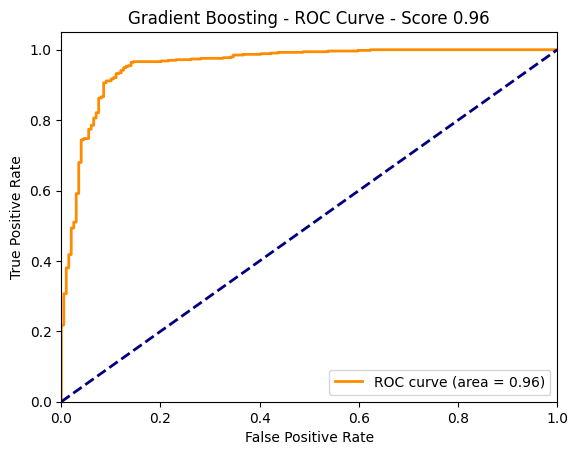

ROC AUC - 0.96


In [77]:
plot_roc_auc(X_test,y_test,gb_grid_search_receive_money.best_estimator_,"Gradient Boosting")

In [78]:
import joblib
import tarfile

# Save the model as a pickle file
pickle_filename = 'receive_money_best_gb'
joblib.dump(gb_grid_search_receive_money.best_estimator_, pickle_filename)

# Save the model as a tar.gz file
tar_filename = 'receive_money_best_gb.tar.gz'
with tarfile.open(tar_filename, "w:gz") as tar:
    tar.add(pickle_filename, arcname='receive_money_best_gb.pkl')

# Save the model as a joblib file
joblib_filename = 'receive_money_best_gb.joblib'
joblib.dump(gb_grid_search.best_estimator_, joblib_filename)

# Save both the pickle file and the joblib file into a tar.gz file
combined_tar_filename = 'best_gb_combined.tar.gz'
with tarfile.open(combined_tar_filename, "w:gz") as tar:
    tar.add(pickle_filename, arcname='receive_money_best_gb.pkl')
    tar.add(joblib_filename, arcname='receive_money_best_gb.joblib')